In [340]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [341]:
SPY_2DAY = pd.read_csv('E-mini S&P 500 minute data (2 days).csv')

In [342]:
def load_data():
    df = pd.read_csv(
        'E-mini S&P 500 minute data (2 days).csv', header=1)
    cols = ["Date Time", "Close"]
    data = df[cols]
    data = data.set_axis(["timestamp", "close"], axis=1)
    return data


def deltas():
    df = load_data()
    df["log"] = np.log(df["close"].astype(float))
    df["deltas"] = df["log"].diff()
    df.dropna(inplace=True)
    final_data = df[["timestamp", "close", "deltas"]]
    #final_data = final_data.set_axis(["timestamp", "close", "deltas"], axis=1)
    return final_data

In [343]:
data = deltas()

In [344]:
data[(data['timestamp'] >= '2022-02-09') & (data['timestamp'] < '2022-02-10')]

,timestamp,close,deltas
1,2022-02-09 07:15:00,4556.50,0.000165
2,2022-02-09 07:16:00,4556.00,-0.000110
3,2022-02-09 07:17:00,4556.25,0.000055
4,2022-02-09 07:18:00,4555.75,-0.000110
5,2022-02-09 07:19:00,4555.25,-0.000110
...,...,...,...
941,2022-02-09 23:55:00,4568.75,0.000219
942,2022-02-09 23:56:00,4569.25,0.000109
943,2022-02-09 23:57:00,4569.75,0.000109
944,2022-02-09 23:58:00,4571.75,0.000438


In [345]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [346]:
df_testing = pd.DataFrame(np.log(data.close).diff().diff(12))
adf_check(df_testing.close.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -16.64043101577222
p-value : 1.6364587817445258e-29
Number of Lags Used : 23
Number of Observations Used : 1882
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [347]:
data

,timestamp,close,deltas
1,2022-02-09 07:15:00,4556.50,0.000165
2,2022-02-09 07:16:00,4556.00,-0.000110
3,2022-02-09 07:17:00,4556.25,0.000055
4,2022-02-09 07:18:00,4555.75,-0.000110
5,2022-02-09 07:19:00,4555.25,-0.000110
...,...,...,...
1915,2022-02-10 17:09:00,4491.00,-0.000612
1916,2022-02-10 17:10:00,4493.00,0.000445
1917,2022-02-10 17:11:00,4493.25,0.000056
1918,2022-02-10 17:12:00,4494.25,0.000223


In [348]:

def AR(p, df):
#Generating the lagged p terms
    df_temp = df

    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['close'].shift(i)

    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_val = pd.DataFrame(df_temp[train_size:df_temp.shape[0]])

    df_train_2 = df_train.dropna()
    #X contains the lagged values ,hence we skip the first column
    try:
        X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
    except:
        return [pd.DataFrame(), pd.DataFrame(), 0, 0, float("inf")]
    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,1].values.reshape(-1,1)

    #Running linear regression to generate the coefficents of lagged terms
    import statsmodels.api as sm
    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

    theta  = np.array([[model.params[0]]] + [[i] for i in model.params[2:]])
    print(X_train.dot(theta))
    intercept = model.params[1]
    df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
    # df_train_2[['Value','Predicted_Values']].plot()

    X_val = df_val.iloc[:,1:].values.reshape(-1,p)
    df_val['Predicted_Values'] = X_val.dot(theta) + intercept
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_val['close'], df_val['Predicted_Values']))
    AIC = model.aic
    BIC = model.bic

    print("The RMSE is :", RMSE,", Value of p : ",p, ", AIC is : ", AIC, ", BIC is : ", BIC)
    return [df_train_2,df_val,theta,intercept,RMSE]

In [349]:
def opt_p (df_testing, low_p, up_p):
    best_p = 0
    best_rmse = float("inf")
    for p in range(low_p, up_p):
        df_train_2,df_val,theta,intercept,RMSE = AR(p, pd.DataFrame(df_testing))
        if RMSE<best_rmse:
            best_p = p
            best_rmse = RMSE
    return best_p, best_rmse


In [350]:
copy = df_testing.copy(deep = True)
#best_p, best_rmse = opt_p(copy, 1, 21)
df_train_2,df_val,theta,intercept,RMSE = AR(11, df_testing)
df_c = pd.concat([df_train_2,df_val])
res = pd.DataFrame()
res['Residuals'] = df_c.close - df_c.Predicted_Values

The RMSE is : 1.000002286511694 , Value of p :  1 , AIC is :  -147204.82943349064 , BIC is :  -147194.17518690613
The RMSE is : 1.0000022865116933 , Value of p :  2 , AIC is :  -125467.10480597326 , BIC is :  -125451.12540913174
The RMSE is : 1.0000022865116944 , Value of p :  3 , AIC is :  -125654.35178261835 , BIC is :  -125633.04855260797
The RMSE is : 1.0000022865116944 , Value of p :  4 , AIC is :  -126674.25349468144 , BIC is :  -126647.62774989166


<ipython-input-348-38f91fe81190>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-348-38f91fe81190>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-348-38f91fe81190>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

The RMSE is : 1.0000022865116933 , Value of p :  5 , AIC is :  -125091.6416713981 , BIC is :  -125059.69473152202
The RMSE is : 1.0000022865116942 , Value of p :  6 , AIC is :  -124935.66871266648 , BIC is :  -124898.40189870306
The RMSE is : 1.0000022865116944 , Value of p :  7 , AIC is :  -124643.85295312744 , BIC is :  -124601.26758738389
The RMSE is : 1.0000022865116938 , Value of p :  8 , AIC is :  -125757.7029535446 , BIC is :  -125709.80035963863
The RMSE is : 1.0000022865116933 , Value of p :  9 , AIC is :  -123274.69818119229 , BIC is :  -123221.4796840544
The RMSE is : 1.000002286511694 , Value of p :  10 , AIC is :  -124764.05016486823 , BIC is :  -124705.51709074409
The RMSE is : 1.000002286511694 , Value of p :  11 , AIC is :  -124639.00512493453 , BIC is :  -124575.15880138725
The RMSE is : 1.0000022865116933 , Value of p :  12 , AIC is :  -123109.06520239862 , BIC is :  -123039.9069583111
The RMSE is : 1.0000022865116944 , Value of p :  13 , AIC is :  -123645.44287641914

<ipython-input-348-38f91fe81190>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-348-38f91fe81190>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
<ipython-input-348-38f91fe81190>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [351]:
res

,Residuals
16,-1.000055
17,-0.999835
18,-1.000220
19,-1.000110
20,-0.999835
...,...
1915,-1.000501
1916,-0.999777
1917,-1.000056
1918,-0.999332


In [352]:
def MA(q,res):

    for i in range(1,q+1):
        res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

    train_size = (int)(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_val = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()

    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    print(theta)
    intercept = lr.intercept_
    res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # res_train_2[['Residuals','Predicted_Values']].plot()

    X_val = res_val.iloc[:,1:].values.reshape(-1,q)
    res_val['Predicted_Values'] = X_val.dot(lr.coef_.T) + lr.intercept_
    res_val[['Residuals','Predicted_Values']].plot()

    from sklearn.metrics import mean_squared_error
    RMSE = np.sqrt(mean_squared_error(res_val['Residuals'], res_val['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_val,theta,intercept,RMSE]

In [353]:
def opt_q (res, low_q, up_q):
    best_q = 0
    best_rmse = float("inf")
    for q in range(low_q, up_q):
        res_train_2,res_val,theta,intercept,RMSE = MA(q, pd.DataFrame(res))
        if RMSE<best_rmse:
            best_q = q
            best_rmse = RMSE
    return best_q, best_rmse

[[0.06464455]]
The RMSE is : 0.0008071286702612449 , Value of q :  1
[[ 0.06696277]
 [-0.03588052]]
The RMSE is : 0.0008049715108105053 , Value of q :  2
[[ 0.06947195]
 [-0.03903372]
 [ 0.06239498]]
The RMSE is : 0.000798116262600392 , Value of q :  3
[[ 0.07142208]
 [-0.04032414]
 [ 0.06432637]
 [-0.03401706]]


<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

The RMSE is : 0.0008014975335292107 , Value of q :  4
[[ 0.07218319]
 [-0.04158208]
 [ 0.06502421]
 [-0.03528055]
 [ 0.02219087]]
The RMSE is : 0.0008028135401522031 , Value of q :  5
[[ 0.07327405]
 [-0.04345598]
 [ 0.06877484]
 [-0.03758202]
 [ 0.02567484]
 [-0.05740456]]
The RMSE is : 0.0008021618313176394 , Value of q :  6
[[ 0.07148325]
 [-0.04261114]
 [ 0.06743633]
 [-0.03541916]
 [ 0.02439558]
 [-0.05537305]
 [-0.03362608]]
The RMSE is : 0.0008021266245484164 , Value of q :  7
[[ 0.07198054]
 [-0.04186035]
 [ 0.06714763]
 [-0.03485982]
 [ 0.0234909 ]
 [-0.05484743]
 [-0.03447648]
 [ 0.01480307]]


<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

The RMSE is : 0.0008033395215392887 , Value of q :  8
[[ 0.07217521]
 [-0.0423179 ]
 [ 0.06652831]
 [-0.03458854]
 [ 0.02302766]
 [-0.05419776]
 [-0.03483964]
 [ 0.01546497]
 [-0.01194131]]


<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


The RMSE is : 0.0008027980080948406 , Value of q :  9
[[ 0.07326901]
 [-0.04295858]
 [ 0.0717115 ]
 [-0.02922823]
 [ 0.02146749]
 [-0.0510451 ]
 [-0.04086791]
 [ 0.01943481]
 [-0.01709728]
 [ 0.09174458]]
The RMSE is : 0.0007993182847022066 , Value of q :  10
[[ 0.07672067]
 [-0.04359978]
 [ 0.07227336]
 [-0.03163793]
 [ 0.0192846 ]
 [-0.0504838 ]
 [-0.04198794]
 [ 0.0221518 ]
 [-0.01883095]
 [ 0.09403814]
 [-0.03856946]]
The RMSE is : 0.0008004128356551129 , Value of q :  11
[[ 0.05856654]
 [ 0.00074433]
 [ 0.0619336 ]
 [-0.02264245]
 [-0.01274126]
 [-0.07712144]
 [-0.03476925]
 [ 0.00622372]
 [ 0.01488066]
 [ 0.07224196]
 [-0.00769042]
 [-0.49839376]]
The RMSE is : 0.0006948542987489512 , Value of q :  12


<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

[[ 0.07695002]
 [ 0.00050493]
 [ 0.05947145]
 [-0.02291969]
 [-0.01296075]
 [-0.07479768]
 [-0.03205142]
 [ 0.006121  ]
 [ 0.0159135 ]
 [ 0.07031408]
 [-0.00800114]
 [-0.5000087 ]
 [ 0.04000961]]
The RMSE is : 0.0006936968295802109 , Value of q :  13
[[ 0.07615822]
 [ 0.01232877]
 [ 0.05934051]
 [-0.02475644]
 [-0.01331175]
 [-0.07486982]
 [-0.03074157]
 [ 0.00806335]
 [ 0.01605615]
 [ 0.07076602]
 [-0.00953557]
 [-0.4999716 ]
 [ 0.03850345]
 [ 0.02523661]]
The RMSE is : 0.000693677640907401 , Value of q :  14
[[ 0.0752714 ]
 [ 0.01117072]
 [ 0.07798145]
 [-0.02499602]
 [-0.01611846]
 [-0.07535822]
 [-0.03093226]
 [ 0.01012008]
 [ 0.01902749]
 [ 0.07127191]
 [-0.00880598]
 [-0.50220409]
 [ 0.03797724]
 [ 0.02281275]
 [ 0.03841971]]


<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

The RMSE is : 0.0006938169833336864 , Value of q :  15
[[ 0.07653841]
 [ 0.01193658]
 [ 0.07925283]
 [-0.04208163]
 [-0.01591354]
 [-0.07275092]
 [-0.03038112]
 [ 0.01036266]
 [ 0.01717927]
 [ 0.06863596]
 [-0.00938691]
 [-0.50284666]
 [ 0.04064279]
 [ 0.02318691]
 [ 0.04068879]
 [-0.03498915]]
The RMSE is : 0.0006944818815048595 , Value of q :  16
[[ 0.07840527]
 [ 0.00967406]
 [ 0.07758162]
 [-0.04400636]
 [ 0.01178795]
 [-0.07302242]
 [-0.03454748]
 [ 0.00944396]
 [ 0.01674933]
 [ 0.07143208]
 [-0.00516628]
 [-0.50183651]
 [ 0.04262018]
 [ 0.01875547]
 [ 0.03993144]
 [-0.0385853 ]
 [ 0.05644439]]
The RMSE is : 0.0006979733851293165 , Value of q :  17


<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

[[ 0.08039137]
 [ 0.00837032]
 [ 0.07952793]
 [-0.04314768]
 [ 0.01353462]
 [-0.09181212]
 [-0.03412481]
 [ 0.01221742]
 [ 0.01732781]
 [ 0.07189948]
 [-0.00725907]
 [-0.5045495 ]
 [ 0.04299363]
 [ 0.01721463]
 [ 0.04286308]
 [-0.03813019]
 [ 0.05906879]
 [-0.03858825]]
The RMSE is : 0.0006980455067075052 , Value of q :  18
[[ 0.07964061]
 [ 0.00973875]
 [ 0.07816437]
 [-0.0418382 ]
 [ 0.01416074]
 [-0.09142776]
 [-0.0451908 ]
 [ 0.01224395]
 [ 0.01919364]
 [ 0.07217776]
 [-0.0069637 ]
 [-0.50574443]
 [ 0.04085928]
 [ 0.01748514]
 [ 0.04182999]
 [-0.0359629 ]
 [ 0.05921485]
 [-0.0371553 ]
 [-0.02227894]]
The RMSE is : 0.0006980771393761055 , Value of q :  19
[[ 0.08078834]
 [ 0.01189624]
 [ 0.0753324 ]
 [-0.03853159]
 [ 0.01078606]
 [-0.09293031]
 [-0.04783997]
 [ 0.04169534]
 [ 0.01881999]
 [ 0.06804645]
 [-0.00748866]
 [-0.50672251]
 [ 0.04465789]
 [ 0.02259662]
 [ 0.04102392]
 [-0.03311103]
 [ 0.05437571]
 [-0.0380433 ]
 [-0.02663379]
 [ 0.05994973]]


<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-352-afb3a02f9080>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

The RMSE is : 0.0006995934124941538 , Value of q :  20
[[ 0.07615822]
 [ 0.01232877]
 [ 0.05934051]
 [-0.02475644]
 [-0.01331175]
 [-0.07486982]
 [-0.03074157]
 [ 0.00806335]
 [ 0.01605615]
 [ 0.07076602]
 [-0.00953557]
 [-0.4999716 ]
 [ 0.03850345]
 [ 0.02523661]]
The RMSE is : 0.000693677640907401 , Value of q :  14


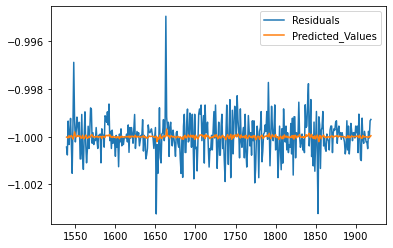

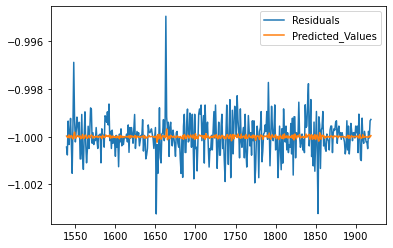

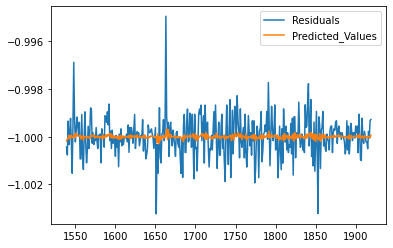

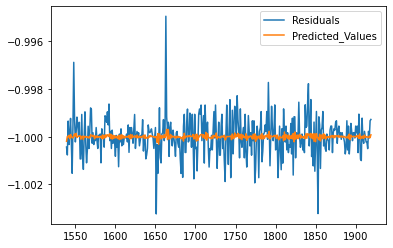

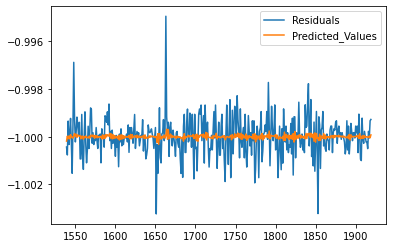

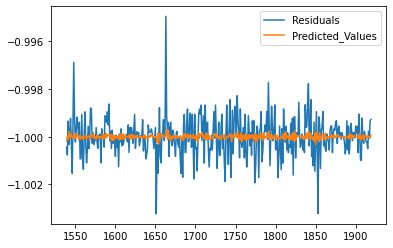

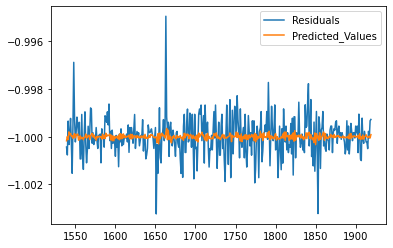

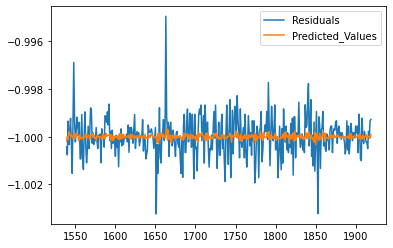

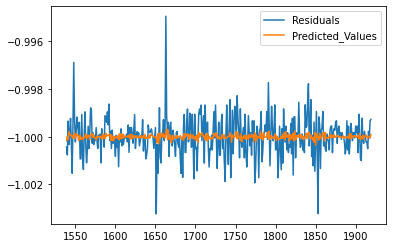

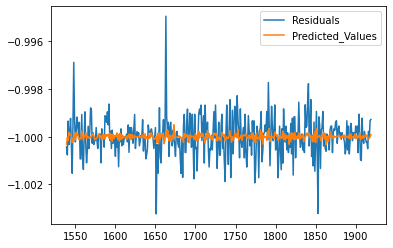

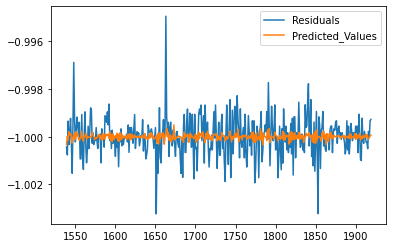

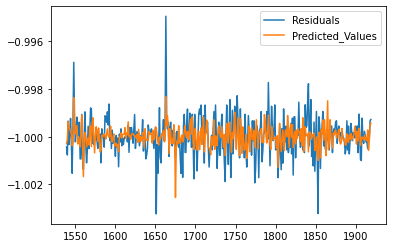

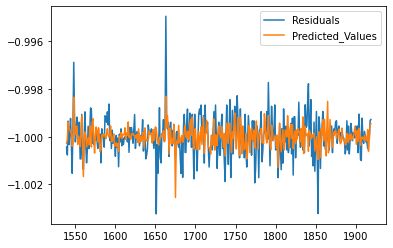

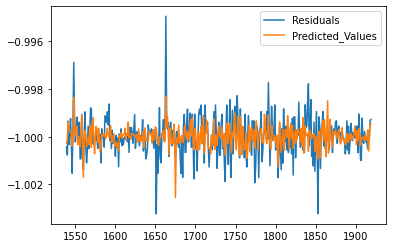

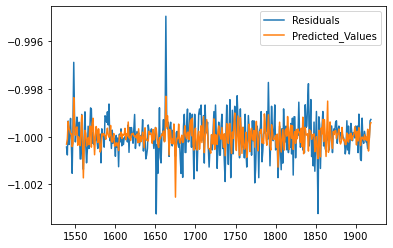

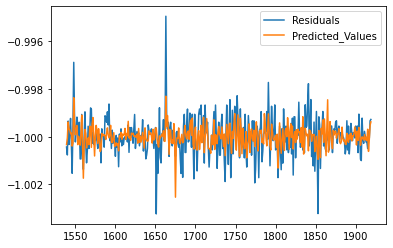

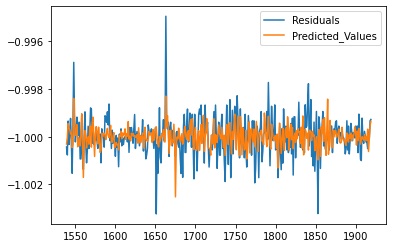

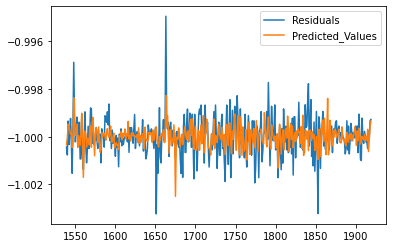

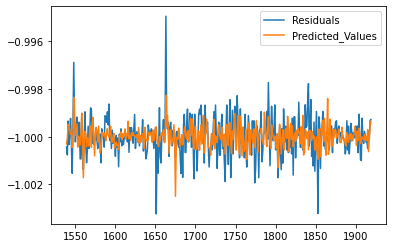

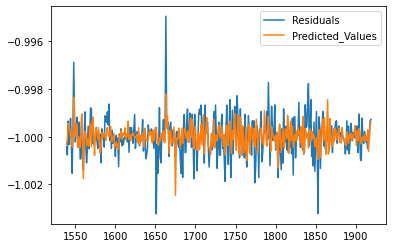

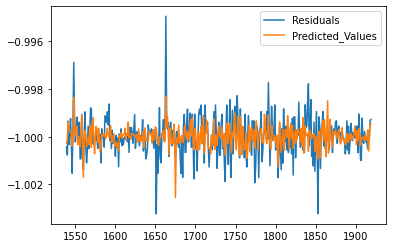

In [354]:

copy = res.copy(deep = True)
best_q, best_rmse = opt_q(copy, 1, 21)
res_train_2,res_val,theta,intercept,RMSE = MA(best_q, res)

(-0.003, 0.002)

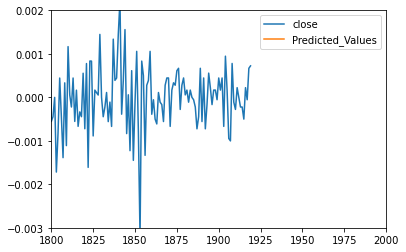

In [355]:
df_c = pd.concat([df_train_2,df_val])

import matplotlib.pyplot as plt
df_c[['close','Predicted_Values']].plot()
plt.xlim(1800, 2000)
plt.ylim(-.003, .002)

# df_c

In [356]:
res = pd.DataFrame()
res['Residuals'] = df_c.close - df_c.Predicted_Values

In [357]:
res_c = pd.concat([res_train_2,res_val])


In [358]:
res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Shifted_values_13,Shifted_values_14,Predicted_Values
30,-0.999890,-1.000110,-0.999561,-0.999835,-0.999890,-1.000220,-1.000110,-0.999945,-1.000055,-0.999835,-0.999835,-1.000110,-1.000220,-0.999835,-1.000055,-0.999858
31,-0.999835,-0.999890,-1.000110,-0.999561,-0.999835,-0.999890,-1.000220,-1.000110,-0.999945,-1.000055,-0.999835,-0.999835,-1.000110,-1.000220,-0.999835,-0.999893
32,-1.000274,-0.999835,-0.999890,-1.000110,-0.999561,-0.999835,-0.999890,-1.000220,-1.000110,-0.999945,-1.000055,-0.999835,-0.999835,-1.000110,-1.000220,-1.000106
33,-1.000165,-1.000274,-0.999835,-0.999890,-1.000110,-0.999561,-0.999835,-0.999890,-1.000220,-1.000110,-0.999945,-1.000055,-0.999835,-0.999835,-1.000110,-1.000110
34,-0.999780,-1.000165,-1.000274,-0.999835,-0.999890,-1.000110,-0.999561,-0.999835,-0.999890,-1.000220,-1.000110,-0.999945,-1.000055,-0.999835,-0.999835,-1.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,-1.000501,-1.000223,-1.000223,-1.000000,-0.999777,-1.000278,-1.000111,-0.999221,-1.001002,-1.000946,-0.999833,-0.999054,-1.000668,-0.999555,-0.999833,-0.999703
1916,-0.999777,-1.000501,-1.000223,-1.000223,-1.000000,-0.999777,-1.000278,-1.000111,-0.999221,-1.001002,-1.000946,-0.999833,-0.999054,-1.000668,-0.999555,-1.000600
1917,-1.000056,-0.999777,-1.000501,-1.000223,-1.000223,-1.000000,-0.999777,-1.000278,-1.000111,-0.999221,-1.001002,-1.000946,-0.999833,-0.999054,-1.000668,-1.000120
1918,-0.999332,-1.000056,-0.999777,-1.000501,-1.000223,-1.000223,-1.000000,-0.999777,-1.000278,-1.000111,-0.999221,-1.001002,-1.000946,-0.999833,-0.999054,-0.999466


In [359]:
df_c.Predicted_Values += res_c.Predicted_Values

<AxesSubplot:>

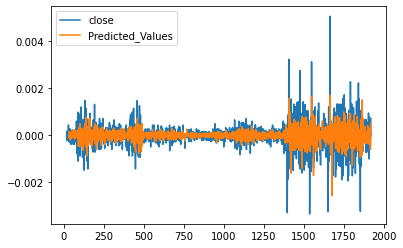

In [360]:
df_c[['close','Predicted_Values']].plot()

In [361]:
df_c.close += np.log(data.close).shift(1)
df_c.close += np.log(data.close).diff().shift(12)
df_c.Predicted_Values += np.log(data.close ).shift(1)
df_c.Predicted_Values += np.log(data.close).diff().shift(12)
df_c.close = np.exp(df_c.close)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [362]:
df_c

,close,Shifted_values_1,Shifted_values_2,Predicted_Values
16,4554.25,-0.000165,0.000165,NaN
17,4554.50,-0.000055,-0.000165,NaN
18,4554.25,0.000165,-0.000055,NaN
19,4554.25,-0.000220,0.000165,NaN
20,4554.75,-0.000110,-0.000220,NaN
...,...,...,...,...
1915,4491.00,-0.000223,-0.000223,4494.583923
1916,4493.00,-0.000501,-0.000223,4489.305792
1917,4493.25,0.000223,-0.000501,4492.959963
1918,4494.25,-0.000056,0.000223,4493.647861


close                0
Shifted_values_1     0
Shifted_values_2     0
Predicted_Values    14
dtype: int64

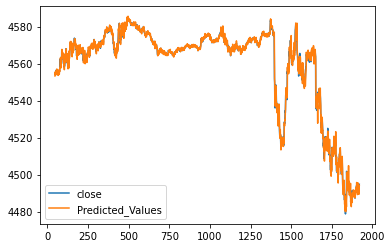

In [363]:
df_c.iloc[30:,:][['close','Predicted_Values']].plot()
np.sum(df_c.isna())